In [209]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Data science
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Geospatial
import contextily as cx
import xarray as xr
import zarr # Not referenced, but required for xarray

# Import Planetary Computer tools
import fsspec
import pystac

# Other
import os
import zipfile
from itertools import cycle
# import geopandas


In [223]:
# df is original, df2 is normalized
df = pd.read_csv("6_primaries.csv")
df = df.drop(['country','continent','stateProvince','Unnamed: 0','gbifID','eventDate','species','key','decimalLatitude', 'decimalLongitude'], 
              1)
df2 = pd.read_csv('6_primaries_normalized.csv').drop(['Unnamed: 0', 'decimalLatitude', 'decimalLongitude'],1)

## Model1: LR on 6 vars, all normalized

In [212]:
# Train model1
model1 = LogisticRegression()
# Separate the predictor variables from the response
X = df2.drop(['occurrenceStatus'], 1)
y = df2.occurrenceStatus.astype(int)
# Fit model
model1.fit(X, y)

LogisticRegression()

F1 Score: 0.6578486055776892
Accuracy: 0.6152329749103943


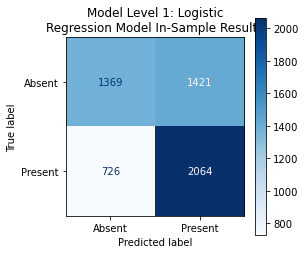

In [213]:
# Testing error with itself
y_predictself = model1.predict(X)
print(f"F1 Score: {np.mean(f1_score(y, y_predictself))}")
print(f"Accuracy: {np.mean(accuracy_score(y, y_predictself))}")

# Draw confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model1, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((4,4))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

# a K-fold shuffle test with itself
cv = KFold(n_splits=10, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

**Test model 1 on other area**

F1 Score: 0.0003312355084465055
Accuracy: 0.32603841000446626


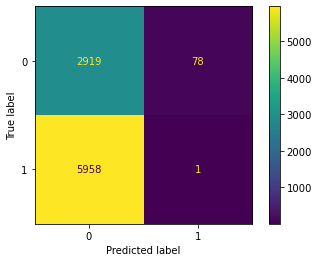

In [224]:
# read in test data (same for model 1 and 2, this data is unbalanced)
df_test_6v = pd.read_csv('model_test_data_11vars.csv').drop(['Unnamed: 0.1', 'Unnamed: 0', 'gbifID', 'eventDate', 'country',
                                                            'continent', 'stateProvince', 'decimalLatitude', 'decimalLongitude',
                                                            'aet_mean', 'def_mean', 'pet_mean', 'vpd_mean','q_mean'],1)
df_test_6v = df_test_6v[ (df_test_6v['species'] == 'Litoria Fallax') | (df_test_6v['species'] == 'Crinia Signifera') ]
X_test_6v = df_test_6v.drop(['species','occurrenceStatus','key'],1)
y_true_6v= df_test_6v['occurrenceStatus']

# Do prediction on test data
y_predicted_6v_1 = model1.predict(X_test_6v)

# Draw confusion matrix 
plot_confusion_matrix(model1,X_test_6v,y_true_6v)

# Print results
print(f"F1 Score: {f1_score(y_true_6v,y_predicted_6v_1)}")
print(f"Accuracy: {accuracy_score(y_true_6v, y_predicted_6v_1)}")

## Model2: LR on 6 vars without normalizing(df)

In [216]:
# Train model2
model2 = LogisticRegression()
# Separate the predictor variables from the response
X = df.drop(['occurrenceStatus'], 1)
y = df.occurrenceStatus.astype(int)
# Fit model
model2.fit(X, y)

LogisticRegression()

F1 Score: 0.675039246467818
Accuracy: 0.6661290322580645


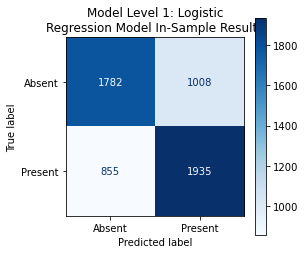

Accuracy: 0.666 (0.196)


In [218]:
# Testing error with itself
y_predictself = model2.predict(X)
print(f"F1 Score: {np.mean(f1_score(y, y_predictself))}")
print(f"Accuracy: {np.mean(accuracy_score(y, y_predictself))}")

# Draw confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(model2, X, y, display_labels=['Absent', 'Present'], cmap='Blues')
disp.figure_.set_size_inches((4,4))
disp.ax_.set_title('Model Level 1: Logistic\nRegression Model In-Sample Results')
plt.show()

# a K-fold shuffle test with itself
cv = KFold(n_splits=1000, random_state=1, shuffle=True)
# evaluate model
scores = cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

**Test model 2 on other area, testing data is same as for model1**

F1 Score: 0.015638575152041704
Accuracy: 0.2409557838320679


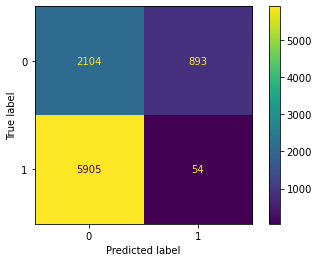

In [225]:
# Do prediction on test data
y_predicted_6v_2 = model2.predict(X_test_6v)

# Draw confusion matrix 
plot_confusion_matrix(model2,X_test_6v,y_true_6v)

# Print results
print(f"F1 Score: {f1_score(y_true_6v,y_predicted_6v_2)}")
print(f"Accuracy: {accuracy_score(y_true_6v, y_predicted_6v_2)}")

# 2. Try do LR on 6 vars, with everything but vaporization normalized

In [156]:
# what is the range of the 6 vars? 
df3 = pd.read_csv("6_primaries.csv")
df3 = df3[['occurrenceStatus','ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean']]
df3

,occurrenceStatus,ppt_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,ws_mean
0,0,73.350000,197.01666,17.966670,7.081669,0.991667,3.368333
1,0,70.383330,194.25000,24.088335,13.050002,1.398333,4.023333
2,0,96.600000,194.60000,23.010002,12.643335,1.372833,3.655000
3,0,63.183334,197.13333,24.073334,11.728335,1.328000,3.355000
4,0,84.050000,194.86667,23.581669,13.054999,1.394667,3.798333
...,...,...,...,...,...,...,...
5575,1,73.933334,192.83333,23.933336,13.291668,1.412000,4.300000
5576,1,73.933334,192.83333,23.933336,13.291668,1.412000,4.300000
5577,1,85.166664,195.68333,23.146670,12.186667,1.352667,3.651667
5578,1,90.416664,194.50000,23.373333,13.133334,1.400833,3.763333


In [157]:
x_data = ['ppt_mean','srad_mean','tmax_mean','tmin_mean','ws_mean']
for xi in (x_data):
    new_name = "normalized_" + xi
    new_col = preprocessing.normalize([df[xi]]).T
    df3[new_name] = new_col
df3 = df3.drop(['ppt_mean','srad_mean','tmax_mean','tmin_mean','ws_mean'],1)
df3.head()

NameError: name 'df' is not defined

In [151]:
full_model2 = LogisticRegression()
# Separate the predictor variables from the response
X2 = df3.drop(['occurrenceStatus'], 1)
y2 = df3.occurrenceStatus.astype(int)
#y_test = df2.occurrenceStatus.astype(int)[:4464]
# Fit model
full_model2.fit(X2, y2)

LogisticRegression()

# 3. Try do LR on 11 vars

In [93]:
df4 = pd.read_csv("model_data_11vars.csv")
df4 = df4.drop(['gbifID', 'eventDate', 'decimalLatitude', 'decimalLongitude', 'species',
       'country', 'continent', 'stateProvince', 'key','Unnamed: 0'], 1)
df4.head()

,occurrenceStatus,aet_mean,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,0,65.416667,30.816667,96.100000,73.350000,8.516667,197.016667,17.966668,7.081668,0.991667,0.536000,3.368333
1,0,65.800000,55.366667,121.150000,70.383333,4.816667,194.250000,24.088335,13.050002,1.398333,0.799000,4.023333
2,0,81.516667,31.250000,112.666667,96.600000,15.433333,194.600000,23.010001,12.643334,1.372833,0.704833,3.655000
3,0,59.983333,56.933333,116.833333,63.183333,3.366667,197.133333,24.073335,11.728335,1.328000,0.816500,3.355000
4,0,75.150000,41.800000,116.916667,84.050000,9.116667,194.866667,23.581668,13.055002,1.394667,0.756167,3.798333


In [5]:
# do a little EDA on the 5 new vars
df4.describe()

,occurrenceStatus,aet_mean,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
count,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000
mean,0.500000,67.925857,46.217360,114.093390,74.810591,7.185717,195.694358,23.101748,11.621844,1.310241,0.752656,3.591389
std,0.500045,6.162993,10.235851,7.662695,9.420066,3.834580,2.067500,1.786972,1.832244,0.122573,0.092084,0.561405
min,0.000000,56.250000,18.383333,92.533333,59.283333,3.033333,192.516667,17.160002,6.461668,0.969000,0.487333,2.633333
25%,0.000000,63.416667,38.833333,111.000000,67.966667,4.800000,194.050000,23.015001,10.835002,1.267833,0.716833,3.083333
50%,0.500000,68.500000,50.250000,116.350000,73.933333,5.583333,195.900000,23.875001,12.168335,1.351833,0.780833,3.601667
75%,1.000000,71.250000,53.233333,120.250000,79.516667,9.116667,197.433333,23.933335,13.185002,1.410000,0.813500,4.141667
max,1.000000,86.766667,61.250000,121.683333,107.950000,22.533333,200.166667,25.020002,14.045002,1.431500,0.936333,4.523333


In [140]:
# compare the test df with train df
df_test.describe()

,occurrenceStatus,aet_mean,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
count,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000,5884.000000
mean,0.490653,72.544556,41.401756,113.929430,83.023527,10.671233,195.472170,23.105283,12.471656,1.372553,0.716602,3.827327
std,0.499955,10.432377,10.463772,4.334658,14.688479,4.820644,7.761184,1.373470,1.319164,0.131305,0.057905,0.572063
min,0.000000,36.383333,16.533333,94.200000,38.316667,1.983333,175.583333,17.533335,6.620001,0.940667,0.519167,2.426667
25%,0.000000,68.366667,35.033333,112.550000,74.866667,7.116667,196.750000,23.260002,12.500002,1.396667,0.695500,3.593333
50%,0.000000,77.483333,35.483333,112.583333,90.416667,13.183333,196.750000,23.260002,12.676668,1.400167,0.698833,3.593333
75%,1.000000,77.483333,46.816667,116.716667,90.416667,13.183333,198.966667,23.745002,13.123336,1.433333,0.724333,4.126667
max,1.000000,96.033333,97.500000,142.100000,124.716667,39.350000,236.050000,26.320001,15.748335,1.756000,1.074000,6.035000


In [147]:
# df4 is original, df5 is normalized. Use either to train model
df5 = df4
x_data = ['ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean','aet_mean','def_mean','pet_mean','vpd_mean','q_mean']
for xi in (x_data):
    new_name = "normalized_" + xi
    new_col = preprocessing.normalize([df5[xi]]).T
    df5[new_name] = new_col
df5 = df5.drop(['ppt_mean','srad_mean','tmax_mean','tmin_mean','vap_mean','ws_mean','aet_mean','def_mean','pet_mean','vpd_mean','q_mean'],1)
df5.describe()

,occurrenceStatus,normalized_ppt_mean,normalized_srad_mean,normalized_tmax_mean,normalized_tmin_mean,normalized_vap_mean,normalized_ws_mean,normalized_aet_mean,normalized_def_mean,normalized_pet_mean,normalized_vpd_mean,normalized_q_mean
count,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000,5580.000000
mean,0.500000,0.013282,0.013386,0.013347,0.013224,0.013329,0.013226,0.013332,0.013070,0.013357,0.013288,0.011811
std,0.500045,0.001672,0.000141,0.001032,0.002085,0.001247,0.002068,0.001210,0.002895,0.000897,0.001626,0.006303
min,0.000000,0.010525,0.013169,0.009914,0.007352,0.009857,0.009698,0.011041,0.005199,0.010833,0.008604,0.004986
25%,0.000000,0.012067,0.013274,0.013297,0.012328,0.012897,0.011355,0.012447,0.010982,0.012995,0.012655,0.007890
50%,0.500000,0.013126,0.013400,0.013794,0.013846,0.013752,0.013264,0.013445,0.014211,0.013621,0.013785,0.009177
75%,1.000000,0.014118,0.013505,0.013828,0.015002,0.014344,0.015253,0.013985,0.015054,0.014078,0.014362,0.014985
max,1.000000,0.019166,0.013692,0.014455,0.015981,0.014562,0.016659,0.017030,0.017322,0.014245,0.016531,0.037037


In [97]:
df4.columns

Index(['occurrenceStatus', 'aet_mean', 'def_mean', 'pet_mean', 'ppt_mean',
       'q_mean', 'srad_mean', 'tmax_mean', 'tmin_mean', 'vap_mean', 'vpd_mean',
       'ws_mean'],
      dtype='object')

In [143]:
# Train model
full_model3 = LogisticRegression(random_state=0)
X3 = df5.drop(['occurrenceStatus'], 1)
y3 = df5.occurrenceStatus.astype(int)
full_model3.fit(X3, y3)

LogisticRegression(random_state=0)

## try to test with other area

In [134]:
# import the 5 regions, 11 vars test data
df_test = pd.read_csv('model_test_data_11vars.csv')
df_test = df_test.drop(['Unnamed: 0.1', 'Unnamed: 0', 'gbifID', 'eventDate', 'country','continent', 'stateProvince', 
                        'decimalLatitude', 'decimalLongitude','key'],1)
df_test = df_test[ (df_test['species'] == 'Litoria Fallax') | (df_test['species'] == 'Crinia Signifera') ]
df_test.head()

,species,occurrenceStatus,aet_mean,def_mean,pet_mean,ppt_mean,q_mean,srad_mean,tmax_mean,tmin_mean,vap_mean,vpd_mean,ws_mean
0,Crinia Signifera,0,72.933333,42.833333,115.683333,81.216667,8.550000,198.766667,23.756668,13.061669,1.433333,0.724333,3.653333
1,Crinia Signifera,0,79.200000,40.066667,119.166667,91.050000,12.083333,199.566667,23.498334,14.031668,1.478333,0.701333,4.345000
2,Crinia Signifera,0,77.483333,35.033333,112.550000,90.416667,13.183333,196.750000,23.260002,12.676668,1.400167,0.695500,3.593333
8,Crinia Signifera,0,57.433333,53.116667,110.516667,61.850000,4.683333,201.200000,23.833335,10.403335,1.233833,0.850667,2.513333
9,Crinia Signifera,0,77.483333,35.033333,112.550000,90.416667,13.183333,196.750000,23.260002,12.676668,1.400167,0.695500,3.593333


In [135]:
df_test['species'].value_counts()

Litoria Fallax      5959
Crinia Signifera    2997
Name: species, dtype: int64

In [144]:
# to balance the test dataset, take 2997 of 1 and 2997 of 0
df_test = df_test[:5884]
df_test['species'].value_counts()

Crinia Signifera    2997
Litoria Fallax      2887
Name: species, dtype: int64

In [145]:
X_test = df_test.drop(['species','occurrenceStatus'],1)
y_true = df_test['occurrenceStatus']

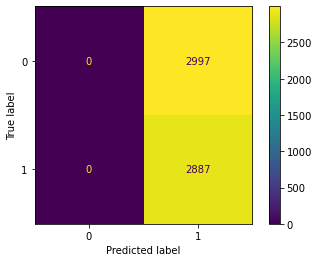

In [146]:
y_predicted = full_model3.predict(X_test)
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
plot_confusion_matrix(full_model3, X_test,y_true )

In [148]:
print(f"F1 Score: {np.mean(f1_score(y_true,y_predicted))}")
print(f"Accuracy: {np.mean(accuracy_score(y_true,y_predicted))}")

F1 Score: 0.6583057804127237
Accuracy: 0.4906526172671652
